<a href="https://colab.research.google.com/github/YapingWu/GoogleColab/blob/main/genpass/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PL模型评估
1.   上传`myspace`和`phpbb`的`tokenizer`模型（`myspace.pkl`，`phpbb.pkl`）
2.   分别上传使用80%数据和全部数据训练的`myspace`和`phpbb`的PL模型（`myspace.h5`，`phpbb.h5`，`myspace_part.h5`，`phpbb_part.h5`）
3. 上传测试数据（`myspace_test.txt`，`phpbb_test.txt`，`rockyou.txt`）





In [1]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## 公共方法

In [2]:
max_lengths = {
    'myspace': 35,
    'phpbb': 21,
}

In [3]:
def sample(preds, temperature=1.0):
  index = np.random.choice(np.arange(len(preds)), p=preds)
  if index == 0:
    index = 1  # 0是保留索引，预测值为0，则预测错误
  prop = preds[index]
  return [index, prop]

In [4]:
# 获取PL模型预测的下一个unit
def get_preds(pl_model, seed_text_list):
  encoded = tokenizer.texts_to_sequences(seed_text_list)  # 对初始文本进行编码
  encoded = pad_sequences(encoded, maxlen=max_length-1, padding='pre')
  preds = pl_model.predict(encoded, batch_size=128)

  rst_list = [sample(pred) for pred in preds]
  result = pd.DataFrame(rst_list, columns=['index', 'prop'])
  result['unit'] = result['index'].apply(lambda x: tokenizer.index_word[x].upper())

  return result

In [9]:
# 生成密码
def generating(pl_model, cnt=100):
    # 使用模型生成密码
    # print('使用PL模型生成{:,}个wordlist：'.format(cnt))
    units = [''] * cnt
    gen_word_list = []
    while cnt > 0:
        preds = get_preds(pl_model, units)
        concat_unit = np.char.add(units, [' '] * cnt)
        concat_unit = np.char.add(concat_unit, preds['unit'])

        new_units = []
        for unit in concat_unit:
            if '<END>' in unit:
                gen_word_list.append(unit)
            else:
                new_units.append(unit)

        # print('{:,}'.format(len(gen_word_list)))
        units = new_units
        cnt = len(units)

    gen_word_list = np.char.replace(gen_word_list, '<END>', '')  # 删除末尾的'<END>'
    gen_word_list = np.char.strip(gen_word_list)  # 去除前后空格

    return gen_word_list

# filename = '{}{}'.format('./', filename)
# print('生成好的wordlist保存到文件：{}'.format(filename))
# np.savetxt(filename, gen_word_list, fmt='%s', delimiter='\n')

# pl_model = load_model('/content/{}_part.h5'.format('myspace'))
# gen_word = generating(pl_model, cnt=1000)
# print(gen_word.shape)
# print(gen_word[:5])

(1000,)
['' '' 'L29' 'L16' 'L12']


In [6]:
# 计算匹配率
def calc_matching_rate(arr1, arr2):
    newarr = np.intersect1d(arr1, arr2, assume_unique=True)
    return len(newarr) / float(len(arr2))

# arr1 = np.array([1, 2, 3, 4])
# arr2 = np.array([3, 4, 5, 6])
# mr = calc_matching_rate(arr1, arr2)
# print(mr)

In [22]:
def get_cur_time():
  curtime = datetime.now() + timedelta(hours=8)
  return curtime.strftime("%Y-%m-%d %H:%M:%S")

# get_cur_time()

'2021-03-06 09:12:07'

## one-site test
1. PL模型：`myspace_part.h5`，测试数据集：`myspace_test.txt`
2. PL模型：`phpbb_part.h5`，测试数据集：`phpbb_test.txt`

### 加载测试数据集

In [7]:
myspace_test = np.loadtxt('/content/myspace_test.txt', dtype=str, delimiter = '\n', skiprows=1)
myspace_test = np.char.strip(myspace_test)
print(myspace_test.shape)
print(myspace_test[:5])

phpbb_test = np.loadtxt('/content/phpbb_test.txt', dtype=str, delimiter = '\n', skiprows=1)
phpbb_test = np.char.strip(phpbb_test)
print(phpbb_test.shape)
print(phpbb_test[:5])

test_data = {
    'myspace': myspace_test,
     'phpbb': phpbb_test
}

(344,)
['L2 S1 L7 D2' 'L2 S1 L3 S1 L8' 'L4 S1 L1 S1 L6 S1 L8 S1 L3 S1 L6 S1 L4'
 'S1 L9 D1 S1' 'L4 D2 L3 D1']
(583,)
['L1 S1 L3 D1 L2 D1' 'L3 D9' 'L5 S1 L14 S1 L2' 'D1 L5 D1 L2' 'L3 D1 S1']


### 生成密码

In [10]:
# 使用 myspace_part 模型生成密码
data_name = 'myspace'
with open('/content/{}.pkl'.format(data_name), 'rb') as file:
    tokenizer = pickle.load(file)
max_length = max_lengths[data_name]
print(tokenizer.index_word)

pl_model = load_model('/content/{}_part.h5'.format(data_name))  # 使用部分数据训练的模型

for alpha in [3, 4, 5, 6]:
  print('{}：使用PL模型生成 1e{} 个wordlist：'.format(get_cur_time(), alpha))
  cnt = int(math.pow(10, alpha))  # 需要生成的密码数量
  loop_times = int(cnt / 1000)
  gen_word = []
  for _ in range(loop_times):
    gen_word.extend(generating(pl_model, cnt=1000))
  
  filename = './{}_{}_part.txt'.format(data_name, alpha)
  print('{}：生成好的wordlist保存到文件：{}'.format(get_cur_time(), filename))
  np.savetxt(filename, gen_word, fmt='%s', delimiter='\n')


{1: '<END>', 2: 's1', 3: 'd1', 4: 'l1', 5: 'l2', 6: 'l4', 7: 'l3', 8: 'd2', 9: 'd3', 10: 'l5', 11: 'l6', 12: 'l7', 13: 'd4', 14: 'l8', 15: 's2', 16: 'l9', 17: 'd6', 18: 'd5', 19: 's3', 20: 'l10', 21: 'd7', 22: 'l11', 23: 'l12', 24: 'l13', 25: 'd8', 26: 'd9', 27: 's5', 28: 's4', 29: 'd10', 30: 'l14', 31: 's6', 32: 'l15', 33: 'l16', 34: 'l18', 35: 'l20', 36: 'l17', 37: 'l21', 38: 'l26', 39: 'l23', 40: 'l19', 41: 'l27', 42: 'l31', 43: 'l22', 44: 'd12', 45: 'd11', 46: 'l36', 47: 'l28', 48: 'l32', 49: 'l30', 50: 'l34', 51: 'l33', 52: 'l24', 53: 'l40', 54: 'l45', 55: 'l56', 56: 's9', 57: 'l25', 58: 'd35', 59: 'd13', 60: 'l29', 61: 'l44', 62: 'l35', 63: 'l48', 64: 'l6341', 65: 's8', 66: 'd14', 67: 'd15', 68: 's44', 69: 's10', 70: 's11', 71: 's12', 72: 's5296'}
使用PL模型生成1,000个wordlist：
生成好的wordlist保存到文件：./myspace_3_part.txt
使用PL模型生成10,000个wordlist：
生成好的wordlist保存到文件：./myspace_4_part.txt
使用PL模型生成100,000个wordlist：
生成好的wordlist保存到文件：./myspace_5_part.txt
使用PL模型生成1,000,000个wordlist：
生成好的wordlist保存到文

In [23]:
# phpbb
data_name = 'phpbb'
with open('/content/{}.pkl'.format(data_name), 'rb') as file:
    tokenizer = pickle.load(file)
max_length = max_lengths[data_name]
# print(tokenizer.index_word)

pl_model = load_model('/content/{}_part.h5'.format(data_name))  # 使用部分数据训练的模型
for alpha in [3, 4, 5, 6]:
  print('{}：使用PL模型生成 1e{} 个wordlist：'.format(get_cur_time(), alpha))
  cnt = int(math.pow(10, alpha))  # 需要生成的密码数量

  loop_times = int(cnt / 1000)
  gen_word = []
  for _ in range(loop_times):
    gen_word.extend(generating(pl_model, cnt=1000))
  
  filename = './{}_{}_part.txt'.format(data_name, alpha)
  print('{}：生成好的wordlist保存到文件：{}'.format(get_cur_time(), filename))
  np.savetxt(filename, gen_word, fmt='%s', delimiter='\n')

2021-03-06 09:13:39：使用PL模型生成 1e3个wordlist：
2021-03-06 09:13:42：生成好的wordlist保存到文件：./phpbb_3_part.txt
2021-03-06 09:13:42：使用PL模型生成 1e4个wordlist：
2021-03-06 09:13:50：生成好的wordlist保存到文件：./phpbb_4_part.txt
2021-03-06 09:13:50：使用PL模型生成 1e5个wordlist：
2021-03-06 09:15:13：生成好的wordlist保存到文件：./phpbb_5_part.txt
2021-03-06 09:15:13：使用PL模型生成 1e6个wordlist：
2021-03-06 09:28:45：生成好的wordlist保存到文件：./phpbb_6_part.txt


### 计算匹配率

In [46]:
x = [3, 4, 5, 6]
y = {
    'myspace': [],
     'phpbb': []
}

for data_name in ['myspace', 'phpbb']:
  for alpha in x:
    gen_psw_file = '/content/{}_{}_part.txt'.format(data_name, alpha)
    gen_psw = np.loadtxt(gen_psw_file, dtype=str, delimiter = '\n')
    gen_psw = np.unique(gen_psw)  # 去重

    mr = calc_matching_rate(gen_psw, test_data[data_name])
    print('data_name：{}, alpha：{}, unique value：{}, mr：{:.2f}%'.format(data_name, alpha, gen_psw.shape[0], mr*100))
    y[data_name].append(mr * 100)

data_name：myspace, alpha：3, unique value：844, mr：15.99%
data_name：myspace, alpha：4, unique value：5197, mr：52.03%
data_name：myspace, alpha：5, unique value：24165, mr：77.33%
data_name：myspace, alpha：6, unique value：111645, mr：85.17%
data_name：phpbb, alpha：3, unique value：911, mr：12.18%
data_name：phpbb, alpha：4, unique value：6301, mr：54.89%
data_name：phpbb, alpha：5, unique value：28015, mr：85.76%
data_name：phpbb, alpha：6, unique value：111006, mr：95.71%


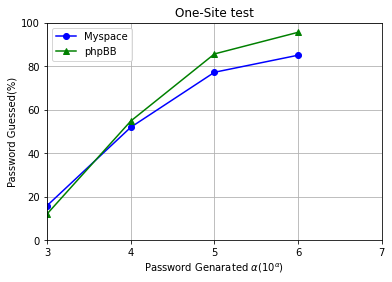

In [47]:
# 画图
plt.title('One-Site test')
plt.plot(x, y['myspace'], 'bo-', label='Myspace')
plt.plot(x, y['phpbb'], 'g^-', label='phpBB')
plt.xlim((3, 7))  # 设置x轴范围
plt.ylim((0, 100))
plt.legend()  # 显示图例

plt.xticks(np.linspace(3, 7, 5))  # 设置x轴刻度


plt.xlabel(r'Password Genarated $\alpha(10^{\alpha})$')  # 设置x轴描述信息
plt.ylabel("Password Guessed(%)")

plt.grid()  # 显示网格

plt.show()
plt.close()

## cross-site test

### 加载测试数据集

In [38]:
rockyou = np.loadtxt('/content/rockyou.txt', dtype=str, delimiter = '\n', skiprows=1)
rockyou = np.char.strip(rockyou)
print(rockyou.shape)
print(rockyou[:5])

(76911,)
['D6' 'D5' 'D9' 'L8' 'D7']


### 生成密码
分别使用phpbb和myspace全部数据训练的PL模型生成密码

In [ ]:
# 使用myspace全部数据训练的PL模型生成密码
data_name = 'myspace'
with open('/content/{}.pkl'.format(data_name), 'rb') as file:
    tokenizer = pickle.load(file)
max_length = max_lengths[data_name]

pl_model = load_model('/content/{}.h5'.format(data_name))  # 使用部分数据训练的模型
for alpha in [3, 4, 5, 6]:
  print('{}：使用PL模型生成 1e{} 个wordlist：'.format(get_cur_time(), alpha))
  cnt = int(math.pow(10, alpha))  # 需要生成的密码数量
  loop_times = int(cnt / 1000)
  gen_word = []
  for _ in range(loop_times):
    gen_word.extend(generating(pl_model, cnt=1000))
  
  filename = './{}{}.txt'.format(data_name, alpha)
  print('{}：生成好的wordlist保存到文件：{}'.format(get_cur_time(), filename))
  np.savetxt(filename, gen_word, fmt='%s', delimiter='\n')

In [40]:
# 使用phpbb全部数据训练的PL模型生成密码
data_name = 'phpbb'
with open('/content/{}.pkl'.format(data_name), 'rb') as file:
    tokenizer = pickle.load(file)
max_length = max_lengths[data_name]

pl_model = load_model('/content/{}.h5'.format(data_name))  # 使用部分数据训练的模型
for alpha in [3, 4, 5, 6]:
  print('{}：使用PL模型生成 1e{} 个wordlist：'.format(get_cur_time(), alpha))
  cnt = int(math.pow(10, alpha))  # 需要生成的密码数量
  loop_times = int(cnt / 1000)
  gen_word = []
  for _ in range(loop_times):
    gen_word.extend(generating(pl_model, cnt=1000))
  
  filename = './{}{}.txt'.format(data_name, alpha)
  print('{}：生成好的wordlist保存到文件：{}'.format(get_cur_time(), filename))
  np.savetxt(filename, gen_word, fmt='%s', delimiter='\n')

2021-03-06 10:17:38：使用PL模型生成 1e3 个wordlist：
2021-03-06 10:17:41：生成好的wordlist保存到文件：./phpbb3.txt
2021-03-06 10:17:41：使用PL模型生成 1e4 个wordlist：
2021-03-06 10:18:03：生成好的wordlist保存到文件：./phpbb4.txt
2021-03-06 10:18:03：使用PL模型生成 1e5 个wordlist：
2021-03-06 10:21:57：生成好的wordlist保存到文件：./phpbb5.txt
2021-03-06 10:21:57：使用PL模型生成 1e6 个wordlist：
2021-03-06 11:02:50：生成好的wordlist保存到文件：./phpbb6.txt


### 计算匹配率

In [45]:
x = [3, 4, 5, 6]
y = {
    'myspace': [],
     'phpbb': []
}

for data_name in ['myspace', 'phpbb']:
  for alpha in x:
    gen_psw_file = '/content/{}{}.txt'.format(data_name, alpha)
    gen_psw = np.loadtxt(gen_psw_file, dtype=str, delimiter = '\n')
    gen_psw = np.unique(gen_psw)  # 去重

    mr = calc_matching_rate(gen_psw, rockyou)
    print('data_name：{}, alpha：{}, unique value：{}, mr：{:.2f}%'.format(data_name, alpha, gen_psw.shape[0], mr * 100))
    y[data_name].append(mr * 100)

data_name：myspace, alpha：3, unique value：876, mr：0.95%
data_name：myspace, alpha：4, unique value：5231, mr：5.02%
data_name：myspace, alpha：5, unique value：24052, mr：15.86%
data_name：myspace, alpha：6, unique value：108111, mr：34.26%
data_name：phpbb, alpha：3, unique value：936, mr：1.03%
data_name：phpbb, alpha：4, unique value：6121, mr：6.31%
data_name：phpbb, alpha：5, unique value：25591, mr：19.26%
data_name：phpbb, alpha：6, unique value：98112, mr：37.13%


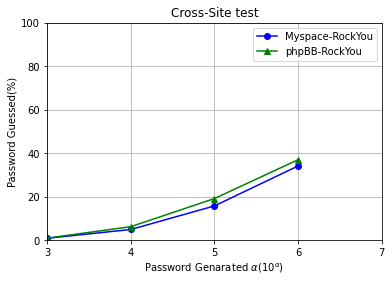

In [43]:
# 画图
plt.title('Cross-Site test')
plt.plot(x, y['myspace'], 'bo-', label='Myspace-RockYou')
plt.plot(x, y['phpbb'], 'g^-', label='phpBB-RockYou')
plt.legend()  # 显示图例

plt.xlim((3, 7))  # 设置x轴范围
plt.ylim((0, 100))

plt.xticks(np.linspace(3, 7, 5))  # 设置x轴刻度

plt.xlabel(r'Password Genarated $\alpha(10^{\alpha})$')  # 设置x轴描述信息
plt.ylabel("Password Guessed(%)")

plt.grid()  # 显示网格

plt.show()
plt.close()

# GenPass模型评估

# 其他命令

## 解压文件

In [7]:
!unzip '/content/lstm_1.zip'
!unzip '/content/tokenizer.zip'

Archive:  /content/lstm_1.zip
  inflating: phpbb.h5                
  inflating: phpbb_part.h5           
  inflating: myspace.h5              
  inflating: myspace_part.h5         
Archive:  /content/tokenizer.zip
  inflating: phpbb.pkl               
  inflating: rockyou.pkl             
  inflating: myspace.pkl             


In [9]:
!unzip '/content/rockyou.zip'

Archive:  /content/rockyou.zip
  inflating: rockyou.txt             
